# SO-ARM 数据采集、训练和评估完整流程

本教程整合了数据采集、模型训练和评估的完整流程，基于 Seeed Studio 官方指南。

**前置条件：**
- ✅ 已完成机械臂校准（01_calibration_and_teleoperation.ipynb）
- ✅ 遥操作功能正常
- ✅ 摄像头已配置

**本教程包含：**
1. 数据采集（录制演示）
2. 数据可视化和验证
3. 数据回放测试
4. 模型训练（ACT/SmolVLA/Pi0）
5. 模型评估和部署

**参考：** [Seeed Studio LeRobot Wiki](https://wiki.seeedstudio.com/cn/lerobot_so100m_new/)

---
## 📊 第一部分：数据采集

### 什么是数据采集？

**数据采集**是通过遥操作录制机械臂执行任务的过程：
- 使用 Leader Arm 演示任务
- Follower Arm 跟随并录制
- 同时记录摄像头画面
- 保存为训练数据集

### 数据质量的重要性

**高质量数据 = 高性能模型**

- 演示要流畅自然
- 包含完整的任务流程
- 保持摄像头视角固定
- 环境光照稳定
- 物体在画面中清晰可见

---
## 🎬 步骤 1: 准备数据采集

### 1.1 定义任务

首先明确您要教机械臂执行什么任务：

**示例任务：**
- 抓取方块并放置到目标位置
- 拿起笔写字
- 分类物体
- 组装零件

**任务设计原则：**
1. **简单明确** - 从单一动作开始
2. **可重复** - 物体位置可以变化但任务逻辑相同
3. **可视化** - 摄像头能看到关键信息
4. **成功可判断** - 有明确的完成标志

### 1.2 环境设置

**工作空间准备：**
- 清理桌面，移除无关物体
- 固定摄像头位置（使用三脚架或支架）
- 确保光照充足且均匀
- 标记物体的起始和目标位置

**摄像头设置：**
- 分辨率：640x480（推荐）
- 帧率：30 fps
- 视角：能看到完整任务区域
- 对焦：清晰对焦到工作区域

### 1.3 配置数据采集参数

In [4]:
# ========== 数据集配置 ==========

# Hugging Face 配置
HF_USER = "wzy04"  # 您的 HF 用户名
DATASET_NAME = "so101_multi_tasks"  # 数据集名称
REPO_ID = f"{HF_USER}/{DATASET_NAME}"

# 任务描述（英文，用于语言条件模型）
TASK_DESCRIPTION = "Pick up the red cube and place it on the green plate"

# 采集参数
NUM_EPISODES = 50  # 推荐至少 50 个
EPISODE_TIME_S = 30  # 每个 episode 最大时长（秒）

# 是否上传到 Hub
PUSH_TO_HUB = False  # 先本地保存，验证后再上传

# 机械臂配置（从校准步骤获得）
ROBOT_PORT = "/dev/ttyACM0"
ROBOT_ID = "my_awesome_follower_arm"  # 您实际的机器人ID
TELEOP_PORT = "/dev/ttyACM1"  # 需要确认您的leader臂端口
TELEOP_ID = "my_so101_leader"

# 摄像头配置（3个摄像头）
CAMERAS = {
    "top": {"index": 10, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"},
    "front": {"index": 8, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"},
    "wrist": {"index": 6, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"}
}

print("✅ 数据采集配置：")
print(f"  数据集: {REPO_ID}")
print(f"  任务: {TASK_DESCRIPTION}")
print(f"  Episodes: {NUM_EPISODES}")
print(f"  上传 Hub: {PUSH_TO_HUB}")
print(f"  机器人: {ROBOT_ID} @ {ROBOT_PORT}")
print(f"  摄像头: {len(CAMERAS)} 个")

✅ 数据采集配置：
  数据集: wzy04/so101_multi_tasks
  任务: Pick up the red cube and place it on the green plate
  Episodes: 50
  上传 Hub: False
  机器人: my_awesome_follower_arm @ /dev/ttyACM0
  摄像头: 3 个


---
## 🎥 步骤 2: 开始录制数据

### 2.1 基础录制命令（本地保存）

In [ ]:
print("在终端运行以下命令开始录制：")
print()
print("lerobot-record \\")
print(f"  --robot.type=so101_follower \\")
print(f"  --robot.port={ROBOT_PORT} \\")
print(f"  --robot.id={ROBOT_ID} \\")
print(f"  --robot.cameras='{{front: {{type: opencv, index_or_path: {CAMERA_INDEX}, \\")
print(f"    width: 640, height: 480, fps: 30, fourcc: \"MJPG\"}}}}' \\")
print(f"  --teleop.type=so101_leader \\")
print(f"  --teleop.port={TELEOP_PORT} \\")
print(f"  --teleop.id={TELEOP_ID} \\")
print(f"  --dataset.repo_id={REPO_ID} \\")
print(f"  --dataset.single_task=\"{TASK_DESCRIPTION}\" \\")
print(f"  --dataset.num_episodes={NUM_EPISODES} \\")
print(f"  --dataset.episode_time_s={EPISODE_TIME_S} \\")
print(f"  --dataset.push_to_hub={str(PUSH_TO_HUB).lower()}")
print()
print("⚠️ 重要提示：")
print("  - 录制开始后，Leader Arm 进入录制模式")
print("  - 操作 Leader Arm 演示任务")
print("  - 完成后按提示键结束当前 episode")
print("  - 重复直到录制完所有 episodes")

### 2.2 录制技巧和最佳实践

#### 录制前
1. **练习几次** - 熟悉动作流程
2. **确认视角** - 检查摄像头画面
3. **准备物体** - 多个物体便于连续录制
4. **测试一个 episode** - 确保系统正常

#### 录制中
1. **动作流畅** - 避免突然加速或停顿
2. **速度适中** - 不要太快或太慢
3. **完成任务** - 每个 episode 包含完整流程
4. **变化位置** - 改变物体起始位置增加多样性

#### 推荐数据分布
- **50 episodes** = 5 个位置 × 每个位置 10 次
- 起始位置 A：10 个成功演示
- 起始位置 B：10 个成功演示  
- 起始位置 C：10 个成功演示
- 起始位置 D：10 个成功演示
- 起始位置 E：10 个成功演示

#### 避免的错误
- ❌ 失败的演示（掉落物体、碰撞）
- ❌ 不完整的动作
- ❌ 摄像头移动或遮挡
- ❌ 复杂背景或人员走动
- ❌ 光照突然变化

---
## 👁️ 步骤 3: 数据可视化

### 3.1 加载数据集

In [2]:
!pip install matplotlib

  Using cached matplotlib-3.10.7-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
  Using cached fonttools-4.60.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (4.8 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)


In [5]:
from lerobot.datasets.lerobot_dataset import LeRobotDataset

print("📂 加载数据集...")

# 从本地加载
dataset = LeRobotDataset(
    repo_id=REPO_ID,
    root=None,  # 使用默认路径
)

print(f"✅ 数据集加载成功")
print(f"  Episodes: {dataset.num_episodes}")
print(f"  Frames: {dataset.num_frames}")
print(f"  FPS: {dataset.fps}")
print(f"  特征: {list(dataset.features.keys())}")

📂 加载数据集...
✅ 数据集加载成功
  Episodes: 72
  Frames: 21624
  FPS: 30
  特征: ['action', 'observation.state', 'observation.images.top', 'observation.images.front', 'observation.images.wrist', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']


### 3.2 可视化第一帧

In [26]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

# 获取第一帧
frame = dataset[54]

# 打印所有可用的键（添加异常处理）
print("数据集包含的键:")
for key in frame.keys():
    try:
        value = frame[key]
        if hasattr(value, 'shape'):
            print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
        else:
            print(f"  {key}: value={value}, type={type(value)}")
    except Exception as e:
        print(f"  {key}: 错误 - {e}")

# 显示图像
image_keys = [k for k in frame.keys() if 'image' in k]
print(f"\n找到 {len(image_keys)} 个图像: {image_keys}")

if image_keys:
    fig, axes = plt.subplots(1, len(image_keys), figsize=(15, 5))
    if len(image_keys) == 1:
        axes = [axes]
    
    for i, key in enumerate(image_keys):
        img = frame[key].numpy()
        # 转换 CHW -> HWC 格式用于显示
        if img.shape[0] == 3:  # CHW格式
            img = np.transpose(img, (1, 2, 0))
        # 归一化到 0-1 范围
        if img.max() > 1.0:
            img = img / 255.0
        axes[i].imshow(img)
        axes[i].set_title(key.split('.')[-1], fontsize=12)  # 只显示摄像头名称
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_first_frame.png', dpi=100, bbox_inches='tight')
    print(f"✅ 图像已保存: dataset_first_frame.png")
    plt.close()

# 显示状态和动作
if 'observation.state' in frame:
    state = frame['observation.state'].numpy()
    print(f"\n关节状态 (shape={state.shape}):")
    print(f"  {state}")
    print(f"  范围: [{state.min():.3f}, {state.max():.3f}], 均值: {state.mean():.3f}")

if 'action' in frame:
    action = frame['action'].numpy()
    print(f"\n动作 (shape={action.shape}):")
    print(f"  {action}")
    print(f"  范围: [{action.min():.3f}, {action.max():.3f}], 均值: {action.mean():.3f}")

# 其他元数据
print(f"\n元数据:")
print(f"  timestamp: {frame['timestamp'].item():.3f}")
print(f"  frame_index: {frame['frame_index'].item()}")
print(f"  episode_index: {frame['episode_index'].item()}")
print(f"  task_index: {frame['task_index'].item()}")

print(f"\n数据集总帧数: {len(dataset)}")

数据集包含的键:
  observation.images.top: shape=torch.Size([3, 480, 640]), dtype=torch.float32
  observation.images.front: shape=torch.Size([3, 480, 640]), dtype=torch.float32
  observation.images.wrist: shape=torch.Size([3, 480, 640]), dtype=torch.float32
  action: shape=torch.Size([6]), dtype=torch.float32
  observation.state: shape=torch.Size([6]), dtype=torch.float32
  timestamp: shape=torch.Size([]), dtype=torch.float32
  frame_index: shape=torch.Size([]), dtype=torch.int64
  episode_index: shape=torch.Size([]), dtype=torch.int64
  index: shape=torch.Size([]), dtype=torch.int64
  task_index: shape=torch.Size([]), dtype=torch.int64
  task: value=Stack the red cup on another cup, type=<class 'str'>

找到 3 个图像: ['observation.images.top', 'observation.images.front', 'observation.images.wrist']
✅ 图像已保存: dataset_first_frame.png

关节状态 (shape=(6,)):
  [  7.3676414 -96.893364   99.36479    54.88918    -4.470588    0.9866103]
  范围: [-96.893, 99.365], 均值: 10.207

动作 (shape=(6,)):
  [  7.6459513 -97.

### 3.3 统计信息

In [11]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# 检查数据集结构
print("数据集属性:")
print([attr for attr in dir(dataset) if not attr.startswith('_')])
print()

# 获取Episode长度 - 方法1: 通过 hf_dataset
try:
    episode_lengths = []
    for ep in range(dataset.num_episodes):
        # 筛选属于该episode的所有帧
        episode_frames = [i for i, ep_idx in enumerate(dataset.hf_dataset['episode_index']) if ep_idx == ep]
        episode_lengths.append(len(episode_frames))
    
    print("📊 数据集统计：")
    print(f"\n总Episodes数: {dataset.num_episodes}")
    print(f"总帧数: {len(dataset)}")
    
    print(f"\nEpisode 帧数：")
    print(f"  平均: {np.mean(episode_lengths):.1f} 帧")
    print(f"  最小: {np.min(episode_lengths)} 帧")
    print(f"  最大: {np.max(episode_lengths)} 帧")
    print(f"  中位数: {np.median(episode_lengths):.1f} 帧")
    print(f"  标准差: {np.std(episode_lengths):.1f} 帧")
    
    # 转换为时间
    fps = dataset.fps
    print(f"\nEpisode 时长 (@ {fps} FPS)：")
    print(f"  平均: {np.mean(episode_lengths)/fps:.1f} 秒")
    print(f"  最小: {np.min(episode_lengths)/fps:.1f} 秒")
    print(f"  最大: {np.max(episode_lengths)/fps:.1f} 秒")
    print(f"  中位数: {np.median(episode_lengths)/fps:.1f} 秒")
    
    # 计算总时长
    total_seconds = sum(episode_lengths) / fps
    total_minutes = total_seconds / 60
    print(f"\n总采集时长: {total_seconds:.1f} 秒 ({total_minutes:.1f} 分钟)")
    
    # 绘制分布
    plt.figure(figsize=(12, 6))
    
    # 子图1: 直方图
    plt.subplot(1, 2, 1)
    plt.hist(episode_lengths, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    plt.axvline(np.mean(episode_lengths), color='red', linestyle='--', 
                label=f'平均: {np.mean(episode_lengths):.1f}')
    plt.axvline(np.median(episode_lengths), color='green', linestyle='--', 
                label=f'中位数: {np.median(episode_lengths):.1f}')
    plt.xlabel('帧数', fontsize=12)
    plt.ylabel('Episode 数量', fontsize=12)
    plt.title('Episode 长度分布 (帧数)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 时长分布
    plt.subplot(1, 2, 2)
    episode_durations = [l/fps for l in episode_lengths]
    plt.hist(episode_durations, bins=20, edgecolor='black', alpha=0.7, color='coral')
    plt.axvline(np.mean(episode_durations), color='red', linestyle='--', 
                label=f'平均: {np.mean(episode_durations):.1f}s')
    plt.axvline(np.median(episode_durations), color='green', linestyle='--', 
                label=f'中位数: {np.median(episode_durations):.1f}s')
    plt.xlabel('时长 (秒)', fontsize=12)
    plt.ylabel('Episode 数量', fontsize=12)
    plt.title(f'Episode 时长分布 ({fps} FPS)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dataset_episode_stats.png', dpi=100, bbox_inches='tight')
    print(f"\n✅ 统计图已保存: dataset_episode_stats.png")
    plt.close()
    
except Exception as e:
    print(f"错误: {e}")
    print("\n尝试方法2: 直接从 episode_index 计算")
    
    # 方法2: 统计每个episode出现的次数
    episode_indices = dataset.hf_dataset['episode_index']
    unique_episodes, counts = np.unique(episode_indices, return_counts=True)
    
    print(f"\n总Episodes数: {len(unique_episodes)}")
    print(f"总帧数: {len(dataset)}")
    print(f"\nEpisode 帧数：")
    print(f"  平均: {np.mean(counts):.1f} 帧")
    print(f"  最小: {np.min(counts)} 帧")
    print(f"  最大: {np.max(counts)} 帧")

数据集属性:
['add_frame', 'batch_encoding_size', 'clear_episode_buffer', 'create', 'create_episode_buffer', 'create_hf_dataset', 'delta_indices', 'delta_timestamps', 'download', 'episode_buffer', 'episodes', 'episodes_since_last_encoding', 'features', 'finalize', 'fps', 'get_episodes_file_paths', 'hf_dataset', 'hf_features', 'image_transforms', 'image_writer', 'latest_episode', 'load_hf_dataset', 'meta', 'num_episodes', 'num_frames', 'pull_from_repo', 'push_to_hub', 'repo_id', 'revision', 'root', 'save_episode', 'start_image_writer', 'stop_image_writer', 'tolerance_s', 'video_backend', 'writer']

📊 数据集统计：

总Episodes数: 72
总帧数: 21624

Episode 帧数：
  平均: 300.3 帧
  最小: 299 帧
  最大: 301 帧
  中位数: 300.0 帧
  标准差: 0.6 帧

Episode 时长 (@ 30 FPS)：
  平均: 10.0 秒
  最小: 10.0 秒
  最大: 10.0 秒
  中位数: 10.0 秒

总采集时长: 720.8 秒 (12.0 分钟)


/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553117/3105755082.py:73: UserWarning: Glyph 24067 (\N{CJK UN


✅ 统计图已保存: dataset_episode_stats.png


---
## 🔄 步骤 4: 数据回放测试

**数据回放**可以验证录制的数据是否正确。

In [ ]:
# 选择要回放的 episode
REPLAY_EPISODE = 0  # 回放第一个 episode

print("在终端运行以下命令回放数据：")
print()
!lerobot-replay \
    --robot.type=so101_follower \
    --robot.port={ROBOT_PORT} \
    --robot.id={ROBOT_ID} \
    --dataset.repo_id={REPO_ID} \
    --dataset.episode={REPLAY_EPISODE}
print()
print("预期行为：")
print("  - Follower Arm 会重现录制的动作")
print("  - 轨迹应该与演示时相似")
print("  - 如果偏差大，可能需要重新录制")

---
## 🧠 第二部分：模型训练

### 支持的策略

LeRobot 支持多种策略，各有特点：

| 策略 | 特点 | 推荐场景 |
|------|------|----------|
| **ACT** | 经典方法，稳定可靠 | 通用任务，初学者 |
| **SmolVLA** | 视觉语言模型，泛化好 | 语言条件任务 |
| **Pi0** | 新一代策略，性能强 | 高精度要求 |

### 训练硬件要求

- **GPU**: 推荐 A100 / RTX 3090 / RTX 4090
- **显存**: 至少 16GB
- **RAM**: 32GB+
- **存储**: 100GB+ 用于 checkpoints

---
## 🚀 步骤 5: 训练 ACT 策略

In [ ]:
# 优化后的ACT训练命令（4060显卡）
export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

lerobot-train \
  --policy.type=act \
  --dataset.repo_id=wzy04/so101_multi_tasks \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --output_dir=outputs/train/act_so101 \
  --steps=300000 \
  --batch_size=18 \
  --policy.device=cuda \
  --policy.push_to_hub=false \
  --policy.use_amp=true \
  --num_workers=12 \
  --wandb.enable=true

🤖 ACT 训练命令（本地数据）：

lerobot-train \
  --policy.type=act \
  --dataset.repo_id=wzy04/so101_multi_tasks \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --output_dir=outputs/train/act_so101 \
  --steps=300000 \
  --batch_size=32 \
  --policy.device=cuda \
  --policy.push_to_hub=false \
  --policy.use_amp=true \
  --num_workers=12 \
  --wandb.enable=true



---
## 🌟 步骤 6: 训练 SmolVLA 策略

In [ ]:
# 方法1: 不推送到Hub（推荐）
lerobot-train \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=wzy04/so101_multi_tasks \
  --dataset.episodes="[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]" \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --batch_size=32 \
  --steps=20000 \
  --output_dir=outputs/train/smolvla_so101 \
  --job_name=smolvla_so101_training \
  --policy.device=cuda \
  --policy.push_to_hub=false \
  --wandb.enable=true \
  --policy.use_amp=true \
  --num_workers=12

## 登录 Hugging Face 账号

huggingface-cli login --token ${HUGGINGFACE_TOKEN} --add-to-git-credential
将您的 Hugging Face 仓库名称存储在一个变量中，以运行以下命令：

HF_USER=$(hf auth whoami | head -n 1)
echo $HF_USER

# 上传本地数据集
source ~/envs/lerobot/bin/activate
cd lerobot

lerobot-upload-dataset \
  --repo-id qwzy123/so101_multi_tasks-1112 \
  --local-dir ~/.cache/huggingface/lerobot/wzy04/so101_multi_tasks

In [ ]:
# 方法2: 推送到Hub（需要添加repo_id）
lerobot-train \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=qwzy123/so101_multi_tasks \
  --dataset.episodes="[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]" \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --batch_size=32 \
  --steps=20000 \
  --save_checkpoint=true \
  --save_freq=2000 \
  --output_dir=outputs/train/so101_multi_tasks-4060-1113 \
  --job_name=smolvla_so101_training-4060-1113 \
  --policy.device=cuda \
  --policy.push_to_hub=true \
  --policy.repo_id=qwzy123/smolvla_so101-4060-1113 \
  --wandb.enable=true \
  --policy.use_amp=true \
  --num_workers=12
  
lerobot-train \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=qwzy123/so101_multi_tasks \
  --dataset.episodes="[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]" \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --batch_size=32 \
  --steps=30000 \
  --save_checkpoint=true \
  --save_freq=2000 \
  --output_dir=outputs/train/so101_multi_tasks-4060-1113 \
  --job_name=smolvla_so101_training-4060-1113 \
  --policy.device=cuda \
  --policy.push_to_hub=true \
  --policy.repo_id=qwzy123/smolvla_so101-4060-1113 \
  --wandb.enable=true \
  --policy.use_amp=true \
  --num_workers=12 \
  --resume=true

🤖 SmolVLA 训练命令：

lerobot-train \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=wzy04/so101_multi_tasks \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --batch_size=32 \
  --steps=20000 \
  --output_dir=outputs/train/smolvla_so101 \
  --job_name=smolvla_so101_training \
  --policy.device=cuda \
  --policy.push_to_hub=false \
  --wandb.enable=true \
  --policy.use_amp=true \
  --num_workers=12

训练时间估算（20k steps）：
  - RTX 4060 Ti: ~8-10 小时
  - RTX 3090: ~4-5 小时
  - A100: ~2-3 小时

⚠️ SmolVLA 依赖安装：
  pip install -e '.[smolvla]'

💡 优势：
  - 小模型（0.45B参数）
  - 支持CPU推理
  - 多任务泛化能力强

📊 训练完成后检查点位置：
  outputs/train/smolvla_so101/checkpoints/last/pretrained_model/



In [ ]:
source ~/envs/lerobot/bin/activate

lerobot-train \
  --output_dir=outputs/train/so101_multi_tasks-4060-1113 \
  --resume=true \
  --steps=20000
这会：

从检查点 010000 继续训练
训练到总共 20000 步（即再训练 10000 步）
保存检查点：012000, 014000, 016000, 018000, 020000
自动使用原来的所有配置（数据集、batch_size等）

如果要继续到30000步：
bashlerobot-train \
  --output_dir=outputs/train/so101_multi_tasks-4060-1113 \
  --resume=true \
  --steps=30000

In [ ]:
如果要改变某些参数（比如降低batch_size）：
bashlerobot-train \
  --output_dir=outputs/train/so101_multi_tasks-4060-1113 \
  --resume=true \
  --steps=20000 \
  --batch_size=40

---
## 🔬 步骤 7: 训练 Pi0 策略

In [20]:
# Pi0 训练配置
PI0_OUTPUT_DIR = "outputs/train/pi0_so101"
PI0_STEPS = 20000  # Pi0推荐2万步
PI0_BATCH_SIZE = 32

print("🤖 Pi0 训练命令：")
print()
print("lerobot-train \\")
print(f"  --policy.type=pi0 \\")
print(f"  --dataset.repo_id={REPO_ID} \\")
print(f"  --rename_map='{RENAME_MAP}' \\")
print(f"  --output_dir={PI0_OUTPUT_DIR} \\")
print(f"  --steps={PI0_STEPS} \\")
print(f"  --batch_size={PI0_BATCH_SIZE} \\")
print(f"  --policy.device=cuda \\")
print(f"  --policy.use_amp=true \\")
print(f"  --num_workers=12 \\")
print(f"  --wandb.enable=true")
print()
print("训练时间估算（20k steps）：")
print("  - RTX 4060 Ti: ~2-3 小时")
print("  - RTX 3090: ~1.5-2 小时")
print("  - A100: ~1 小时")
print()
print("💡 Pi0 是视觉-语言-动作模型，训练较快")
print()

🤖 Pi0 训练命令：

lerobot-train \
  --policy.type=pi0 \
  --dataset.repo_id=wzy04/so101_multi_tasks \
  --rename_map='{"observation.images.front": "observation.images.camera1", "observation.images.top": "observation.images.camera2", "observation.images.wrist": "observation.images.camera3"}' \
  --output_dir=outputs/train/pi0_so101 \
  --steps=20000 \
  --batch_size=32 \
  --policy.device=cuda \
  --policy.use_amp=true \
  --num_workers=12 \
  --wandb.enable=true

训练时间估算（20k steps）：
  - RTX 4060 Ti: ~2-3 小时
  - RTX 3090: ~1.5-2 小时
  - A100: ~1 小时

💡 Pi0 是视觉-语言-动作模型，训练较快



---
## 📊 步骤 8: 监控训练

### 8.1 查看训练日志

In [21]:
from pathlib import Path

# 选择要检查的输出目录
output_dir = Path(ACT_OUTPUT_DIR)

if output_dir.exists():
    # 查找 checkpoints
    checkpoints = sorted(output_dir.glob("checkpoints/*"))
    
    if checkpoints:
        print(f"📦 找到 {len(checkpoints)} 个 checkpoints:\n")
        for cp in checkpoints:
            print(f"  - {cp.name}")
        print(f"\n✅ 最新: {checkpoints[-1].name}")
    else:
        print("⚠️ 还没有 checkpoints")
        print("训练可能刚开始")
else:
    print("⚠️ 输出目录不存在")
    print(f"请确认训练已开始: {output_dir}")

⚠️ 输出目录不存在
请确认训练已开始: outputs/train/act_so101


---
## 🎯 第三部分：模型评估和部署

### 什么是评估？

**评估 (Evaluation)** 是测试训练好的模型在实际机械臂上的表现：
- 加载训练好的 checkpoint
- 让机械臂自主执行任务
- 统计成功率和性能

**与训练数据回放的区别：**
- 回放：重现录制的动作（已知正确）
- 评估：模型自主决策（测试学习效果）

---
## 🧪 步骤 9: 评估模型

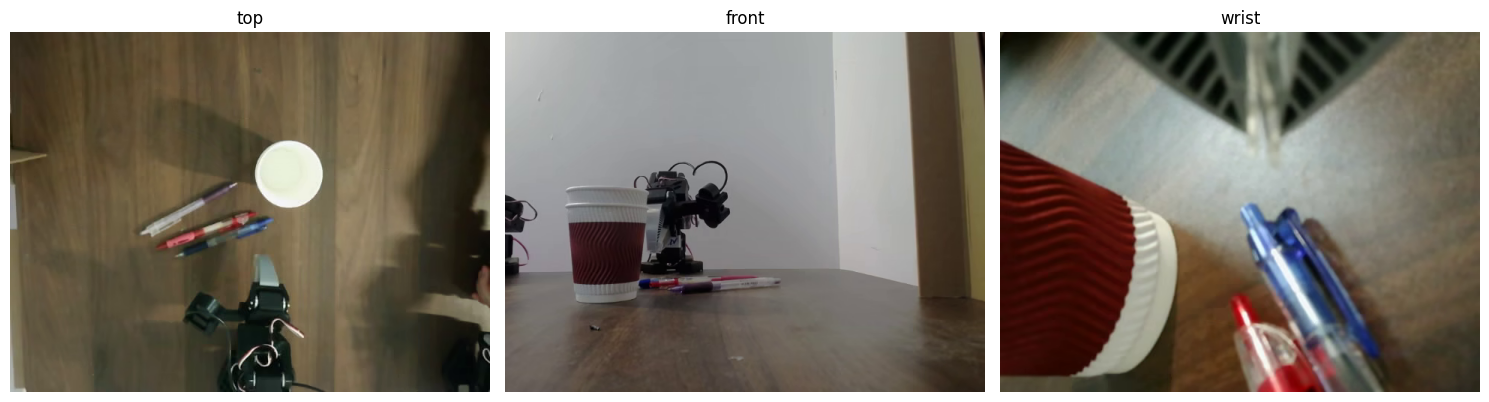

✓ camera1_top: (480, 640, 3)
✓ camera2_front: (480, 640, 3)
✓ camera3_wrist: (480, 640, 3)


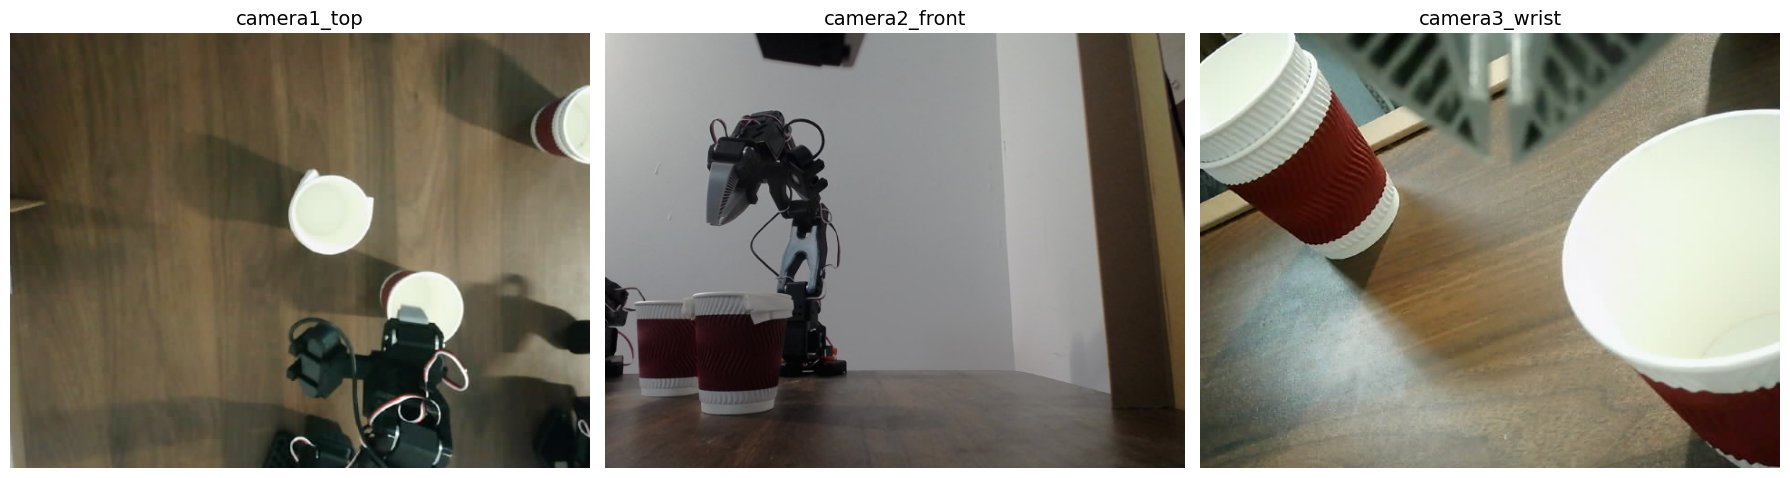

In [78]:
# 在notebook第一个cell运行检查摄像头是否正常
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np

# 摄像头配置
cameras = {
    'camera1_top': 10,
    'camera2_front': 8,
    'camera3_wrist': 6
}

# 读取一帧
frames = {}
for name, idx in cameras.items():
    cap = cv2.VideoCapture(idx)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M','J','P','G'))
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    ret, frame = cap.read()
    if ret:
        # BGR转RGB
        frames[name] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print(f"✓ {name}: {frame.shape}")
    else:
        print(f"✗ {name}: 读取失败")
    
    cap.release()

# 显示图像
if frames:
    fig, axes = plt.subplots(1, len(frames), figsize=(18, 6))
    
    for i, (name, frame) in enumerate(frames.items()):
        axes[i].imshow(frame)
        axes[i].set_title(name, fontsize=14)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("错误：没有读取到任何图像")

可用撤销

In [88]:
#!cd /home/wzy/lerobot
#!source /home/wzy/envs/lerobot/bin/activate
# front是Camera1 top是cCamera2 wrist是Camera3
# 测试训练好的模型（AI自主控制机器人）
!lerobot-record \
  --robot.type=so101_follower \
  --robot.port=/dev/ttyACM0 \
  --robot.id=my_awesome_follower_arm \
  --robot.cameras='{"camera1": {"type": "opencv", "index_or_path": 8, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"}, "camera2": {"type": "opencv", "index_or_path": 10, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"}, "camera3": {"type": "opencv", "index_or_path": 6, "width": 640, "height": 480, "fps": 30, "fourcc": "MJPG"}}' \
  --policy.path=/home/wzy/lerobot/outputs/train/so101_multi_tasks/checkpoints/last/pretrained_model \
  --dataset.single_task="Stack the cup on another cup" \
  --dataset.num_episodes=50 \
  --dataset.episode_time_s=120 \
  --dataset.repo_id=qwzy123/eval_put_cup_2 \
  --dataset.push_to_hub=false

INFO 2025-11-14 07:09:37 t_record.py:375 {'dataset': {'episode_time_s': 120,
             'fps': 30,
             'num_episodes': 50,
             'num_image_writer_processes': 0,
             'num_image_writer_threads_per_camera': 4,
             'private': False,
             'push_to_hub': False,
             'rename_map': {},
             'repo_id': 'qwzy123/eval_put_cup_2',
             'reset_time_s': 60,
             'root': None,
             'single_task': 'Stack the cup on another cup',
             'tags': None,
             'video': True,
             'video_encoding_batch_size': 1},
 'display_data': False,
 'play_sounds': True,
 'policy': {'adapt_to_pi_aloha': False,
            'add_image_special_tokens': False,
            'attention_mode': 'cross_attn',
            'chunk_size': 50,
            'device': 'cuda',
            'empty_cameras': 0,
            'expert_width_multiplier': 0.75,
            'freeze_vision_encoder': True,
            'input_features': {'observat

In [41]:
# 验证任务1（杯子堆叠）
!lerobot-record \
    --robot.type=so101_follower \
    --robot.port=/dev/ttyACM0 \
    --robot.id=my_awesome_follower_arm \
    --robot.cameras="{ top: {type: opencv, index_or_path: 10, width: 640, height: 480, fps: 30, fourcc: \"MJPG\"},front: {type: opencv, index_or_path: 8, width: 640, height: 480, fps: 30, fourcc: \"MJPG\"}, wrist: {type: opencv, index_or_path: 6, width: 640, height: 480, fps: 30, fourcc: \"MJPG\"}}" \
    --dataset.single_task="Stack the red cup on another cup" \
    --dataset.num_episodes=10 \
    --dataset.episode_time_s=60 \
    --dataset.repo_id=qwzy123/eval_cup_stacking \
    --dataset.push_to_hub=false \
    --policy.path=./lerobot/outputs/train/so101_multi_tasks/checkpoints/last/pretrained_model 




Traceback (most recent call last):
  File "/home/wzy/envs/lerobot/lib/python3.10/site-packages/draccus/parsers/decoding.py", line 159, in decode_dataclass
    instance = origin(**init_args)
  File "<string>", line 10, in __init__
  File "/home/wzy/lerobot/src/lerobot/scripts/lerobot_record.py", line 195, in __post_init__
    self.policy = PreTrainedConfig.from_pretrained(policy_path, cli_overrides=cli_overrides)
  File "/home/wzy/lerobot/src/lerobot/configs/policies.py", line 178, in from_pretrained
    config_file = hf_hub_download(
  File "/home/wzy/envs/lerobot/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 106, in _inner_fn
    validate_repo_id(arg_value)
  File "/home/wzy/envs/lerobot/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 154, in validate_repo_id
    raise HFValidationError(
huggingface_hub.errors.HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './lerobot/outputs/train/so101_multi_tas

---
## 📈 步骤 10: 分析评估结果

In [22]:
# 手动记录评估结果
print("评估记录表：")
print()
print("| Episode | 成功? | 失败原因 | 备注 |")
print("|---------|-------|---------|------|")
for i in range(EVAL_EPISODES):
    print(f"| {i+1:2d}      |       |         |      |")
print()
print("成功率 = 成功次数 / 总次数")
print()
print("性能标准：")
print("  优秀: ≥ 90%")
print("  良好: 70-90%")
print("  一般: 50-70%")
print("  需改进: < 50%")

评估记录表：

| Episode | 成功? | 失败原因 | 备注 |
|---------|-------|---------|------|


NameError: name 'EVAL_EPISODES' is not defined

---
## 🔧 常见问题和解决方案

### 数据采集问题

**Q1: 录制时机械臂动作卡顿？**

A: 检查：
- USB 是否直连（不要用 Hub）
- 摄像头分辨率是否过高
- 系统资源是否充足

**Q2: 数据集保存在哪里？**

A: 默认保存在 `~/.cache/huggingface/lerobot/`

### 训练问题

**Q3: 训练显存不足（OOM）？**

A: 减小 batch_size：
- A100: 32-64
- RTX 3090: 16-32  
- RTX 3080: 8-16

**Q4: 训练多久合适？**

A: 观察 loss 曲线：
- Loss 持续下降：继续训练
- Loss 平稳：可以停止
- Loss 上升：过拟合，用早期 checkpoint

### 评估问题

**Q5: 评估时报错 "File exists"？**

A: 删除之前的评估数据：
```bash
rm -rf ~/.cache/huggingface/lerobot/eval_*
```

**Q6: 模型表现不好怎么办？**

A: 改进策略：
1. 采集更多数据（100+ episodes）
2. 提高数据质量（更流畅的演示）
3. 增加数据多样性（更多起始位置）
4. 延长训练时间
5. 尝试不同的策略

---
## ✅ 完成！

恭喜您完成了从数据采集到模型评估的完整流程！

### 总结

您已经学会了：
- ✅ 如何录制高质量的演示数据
- ✅ 数据可视化和验证方法
- ✅ 训练三种不同的策略（ACT/SmolVLA/Pi0）
- ✅ 评估和部署训练好的模型
- ✅ 故障排查和性能优化

### 下一步

根据评估结果：

**如果成功率 ≥ 70%：**
- 尝试更复杂的任务
- 探索多任务学习
- 分享您的模型和经验

**如果成功率 < 70%：**
- 分析失败案例
- 采集针对性数据
- 调整训练超参数
- 尝试不同策略

### 进阶主题

- 多任务学习
- 语言条件控制
- 迁移学习
- 在线学习和微调

---

**参考资源：**
- [Seeed Studio Wiki](https://wiki.seeedstudio.com/cn/lerobot_so100m_new/)
- [LeRobot 文档](https://huggingface.co/docs/lerobot)
- [社区 Discord](https://discord.com/invite/s3KuuzsPFb)

**🎉 祝您训练出优秀的机械臂策略！**